<a href="https://colab.research.google.com/github/dantidn/TensorFlow-Advanced-Techniques-Specialization/blob/main/C3_W4_Lab_1_FashionMNIST_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Class Activation Maps with Fashion MNIST

In this lab, you will see how to implement a simple class activation map (CAM) of a model trained on the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). This will show what parts of the image the model was paying attention to when deciding the class of the image. Let's begin!

In [1]:
# Install packages for compatibility

# NOTE: You can safely ignore errors about version incompatibility of
# Colab-bundled packages (e.g. xarray, pydantic, etc.)

!pip install tf-keras==2.15 --quiet
!pip install tensorflow==2.15 --quiet
!pip install keras==2.15 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.68 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.


## Imports

In [2]:
import keras
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
import scipy as sp

## Download and Prepare the Data

In [3]:
# load the Fashion MNIST dataset
(X_train,Y_train),(X_test,Y_test)  = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [4]:
# Put an additional axis for the channels of the image.
# Fashion MNIST is grayscale so we place 1 at the end. Other datasets
# will need 3 if it's in RGB.
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

# Normalize the pixel values from 0 to 1
X_train = X_train/255
X_test  = X_test/255

# Cast to float
X_train = X_train.astype('float')
X_test  = X_test.astype('float')

In [5]:
def show_img(img):
    '''utility function for reshaping and displaying an image'''

    # convert to float array if img is not yet preprocessed
    img  = np.array(img,dtype='float')

    # remove channel dimension
    img = img.reshape((28,28))

    # display image
    plt.imshow(img)

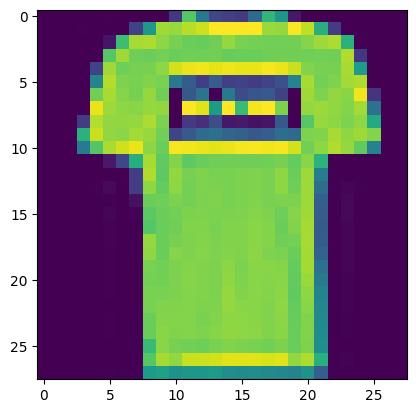

In [6]:
# test the function for the first train image. you can vary the index of X_train
# below to see other images

show_img(X_train[1])

## Build the Classifier

Let's quickly recap how we can build a simple classifier with this dataset.

### Define the Model

You can build the classifier with the model below. The image will go through 4 convolutions followed by pooling layers. The final Dense layer will output the probabilities for each class.

In [7]:
# use the Sequential API
model = Sequential()

# notice the padding parameter to recover the lost border pixels when doing the convolution
model.add(Conv2D(16,input_shape=(28,28,1),kernel_size=(3,3),activation='relu',padding='same'))
# pooling layer with a stride of 2 will reduce the image dimensions by half
model.add(MaxPooling2D(pool_size=(2,2)))

# pass through more convolutions with increasing filters
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))

# use global average pooling to take into account lesser intensity pixels
model.add(GlobalAveragePooling2D())

# output class probabilities
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0

### Train the Model

In [8]:
# configure the training
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

# train the model. just run a few epochs for this test run. you can adjust later.
model.fit(X_train,Y_train,batch_size=32, epochs=5, validation_split=0.1, shuffle=True)

Epoch 1/5
1688/1688 [==============================] - 66s 38ms/step - loss: 0.5983 - accuracy: 0.7805 - val_loss: 0.4008 - val_accuracy: 0.8565
Epoch 2/5
1688/1688 [==============================] - 55s 33ms/step - loss: 0.3670 - accuracy: 0.8676 - val_loss: 0.3175 - val_accuracy: 0.8847
Epoch 3/5
1688/1688 [==============================] - 55s 33ms/step - loss: 0.3138 - accuracy: 0.8864 - val_loss: 0.3433 - val_accuracy: 0.8687
Epoch 4/5
1688/1688 [==============================] - 57s 34ms/step - loss: 0.2787 - accuracy: 0.8980 - val_loss: 0.2712 - val_accuracy: 0.8983
Epoch 5/5
1688/1688 [==============================] - 55s 33ms/step - loss: 0.2539 - accuracy: 0.9068 - val_loss: 0.2640 - val_accuracy: 0.9065


## Generate the Class Activation Map

To generate the class activation map, we want to get the features detected in the last convolution layer and see which ones are most active when generating the output probabilities. In our model above, we are interested in the layers shown below.

In [9]:
# final convolution layer
print(model.layers[-3].name)

# global average pooling layer
print(model.layers[-2].name)

# output of the classifier
print(model.layers[-1].name)

conv2d_3
global_average_pooling2d
dense


You can now create your CAM model as shown below.

In [10]:
# same as previous model but with an additional output
cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496 

Use the CAM model to predict on the test set, so that it generates the features and the predicted probability for each class (`results`).

In [11]:
# get the features and results of the test images using the newly created model
features,results = cam_model.predict(X_test)

# shape of the features
print("features shape: ", features.shape)
print("results shape", results.shape)

313/313 [==============================] - 4s 11ms/step
features shape:  (10000, 3, 3, 128)
results shape (10000, 10)


You can generate the CAM by getting the dot product of the class activation features and the class activation weights.

You will need the weights from the Global Average Pooling layer (GAP) to calculate the activations of each feature given a particular class.
- Note that you'll get the weights from the dense layer that follows the global average pooling layer.
  - The last conv2D layer has (h,w,depth) of (3 x 3 x 128), so there are 128 features.
  - The global average pooling layer collapses the h,w,f (3 x 3 x 128) into a dense layer of 128 neurons (1 neuron per feature).
  - The activations from the global average pooling layer get passed to the last dense layer.
  - The last dense layer assigns weights to each of those 128 features (for each of the 10 classes),
  - So the weights of the last dense layer (which immmediately follows the global average pooling layer) are referred to in this context as the "weights of the global average pooling layer".

For each of the 10 classes, there are 128 features, so there are 128 feature weights, one weight per feature.

In [12]:
# these are the weights going into the softmax layer
last_dense_layer = model.layers[-1]

# get the weights list.  index 0 contains the weights, index 1 contains the biases
gap_weights_l = last_dense_layer.get_weights()

print("gap_weights_l index 0 contains weights ", gap_weights_l[0].shape)
print("gap_weights_l index 1 contains biases ", gap_weights_l[1].shape)

# shows the number of features per class, and the total number of classes
# Store the weights
gap_weights = gap_weights_l[0]

print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")

gap_weights_l index 0 contains weights  (128, 10)
gap_weights_l index 1 contains biases  (10,)
There are 128 feature weights and 10 classes.


Now, get the features for a specific image, indexed between 0 and 999.

In [13]:
# Get the features for the image at index 0
idx = 0
features_for_img = features[idx,:,:,:]

print(f"The features for image index {idx} has shape (height, width, num of feature channels) : ", features_for_img.shape)

The features for image index 0 has shape (height, width, num of feature channels) :  (3, 3, 128)


The features have height and width of 3 by 3.  Scale them up to the original image height and width, which is 28 by 28.

In [14]:
features_for_img_scaled = sp.ndimage.zoom(features_for_img, (28/3, 28/3,1), order=2)

# Check the shape after scaling up to 28 by 28 (still 128 feature channels)
print("features_for_img_scaled up to 28 by 28 height and width:", features_for_img_scaled.shape)

features_for_img_scaled up to 28 by 28 height and width: (28, 28, 128)


For a particular class (0...9), get the 128 weights.

Take the dot product with the scaled features for this selected image with the weights.

The shapes are:
scaled features: (h,w,depth) of (28 x 28 x 128).
weights for one class: 128

The dot product produces the class activation map, with the shape equal to the height and width of the image: 28 x 28.

In [15]:
# Select the weights that are used for a specific class (0...9)
class_id = 0
# take the dot product between the scaled image features and the weights for
gap_weights_for_one_class = gap_weights[:,class_id]

print("features_for_img_scaled has shape ", features_for_img_scaled.shape)
print("gap_weights_for_one_class has shape ", gap_weights_for_one_class.shape)
# take the dot product between the scaled features and the weights for one class
cam = np.dot(features_for_img_scaled, gap_weights_for_one_class)

print("class activation map shape ", cam.shape)

features_for_img_scaled has shape  (28, 28, 128)
gap_weights_for_one_class has shape  (128,)
class activation map shape  (28, 28)


### Conceptual interpretation
To think conceptually about what what you're doing and why:
- In the 28 x 28 x 128 feature map, each of the 128 feature filters is tailored to look for a specific set of features (for example, a shoelace).  
  - The actual features are learned, not selected by you directly.
- Each of the 128 weights for a particular class decide how much weight to give to each of the 128 features, for that class.
  - For instance, for the "shoe" class, it may have a higher weight for the feature filters that look for shoelaces.
- At each of the 28 by 28 pixels, you can take the vector of 128 features and compare them with the vector of 128 weights.  
  - You can do this comparison with a dot product.
  - The dot product results in a scalar value at each pixel.
  - Apply this dot product across all of the 28 x 28 pixels.
  - The scalar result of the dot product will be larger when the image both has the particular feature (e.g. shoelace), and that feature is also weighted more heavily for the particular class (e.g shoe).
  
So you've created a matrix with the same number of pixels as the image, where the value at each pixel is higher when that pixel is relevant to the prediction of a particular class.

Here is the function that implements the Class activation map calculations that you just saw.

In [16]:
def show_cam(image_index):
  '''displays the class activation map of a particular image'''

  # takes the features of the chosen image
  features_for_img = features[image_index,:,:,:]

  # get the class with the highest output probability
  prediction = np.argmax(results[image_index])

  # get the gap weights at the predicted class
  class_activation_weights = gap_weights[:,prediction]

  # upsample the features to the image's original size (28 x 28)
  class_activation_features = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=2)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  print('Predicted Class = ' +str(prediction)+ ', Probability = ' + str(results[image_index][prediction]))

  # show the upsampled image
  plt.imshow(np.squeeze(X_test[image_index],-1), alpha=0.5)

  # strongly classified (95% probability) images will be in green, else red
  if results[image_index][prediction]>0.95:
    cmap_str = 'Greens'
  else:
    cmap_str = 'Reds'

  # overlay the cam output
  plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

  # display the image
  plt.show()

You can now test generating class activation maps. Let's use the utility function below.

In [17]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates CAMs
    for the first `num_maps`(int) of the `desired_class`(int)
    '''

    counter = 0

    if desired_class < 10:
        print("please choose a class less than 10")

    # go through the first 10000 images
    for i in range(0,10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i)

For class 8 (handbag), you'll notice that most of the images have dark spots in the middle and right side.
- This means that these areas were given less importance when categorizing the image.
- The other parts such as the outline or handle contribute more when deciding if an image is a handbag or not.

Observe the other classes and see if there are also other common areas that the model uses more in determining the class of the image.

please choose a class less than 10
Predicted Class = 7, Probability = 0.99985814


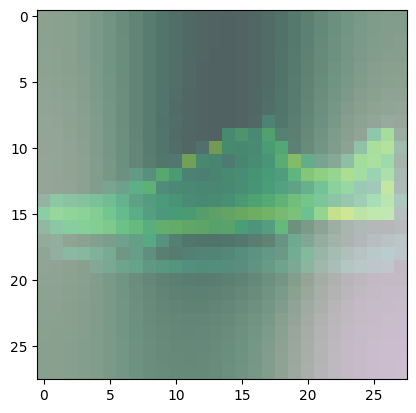

Predicted Class = 7, Probability = 0.99985504


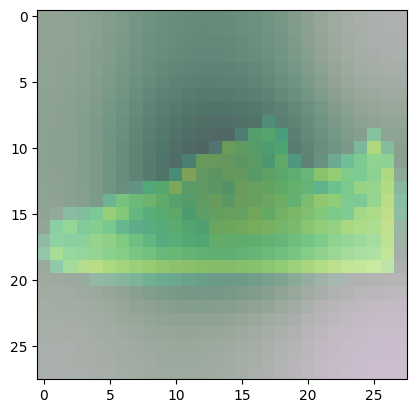

Predicted Class = 7, Probability = 0.99997765


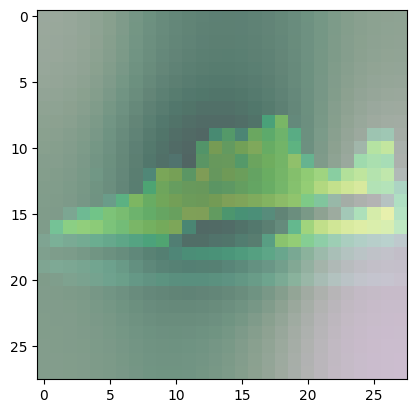

Predicted Class = 7, Probability = 0.99962944


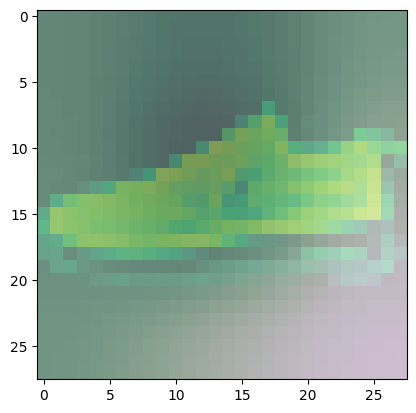

Predicted Class = 7, Probability = 0.96084267


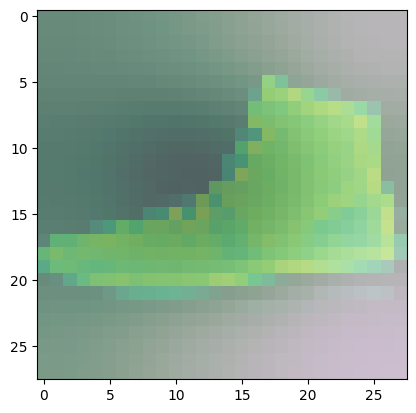

Predicted Class = 7, Probability = 0.9784091


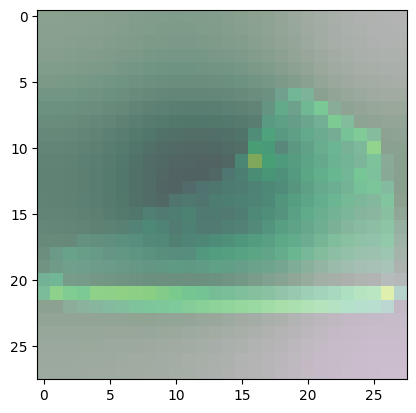

Predicted Class = 7, Probability = 0.9996268


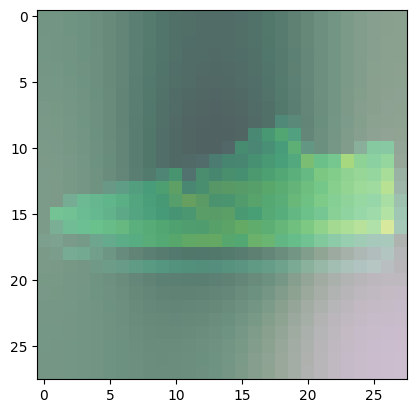

Predicted Class = 7, Probability = 0.98817474


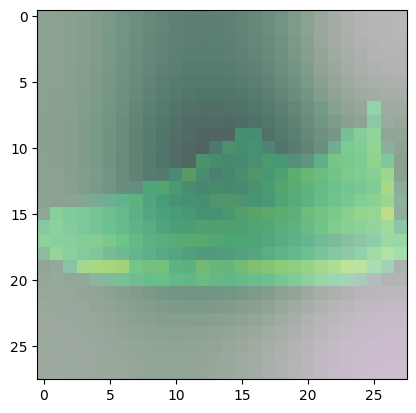

Predicted Class = 7, Probability = 0.9967934


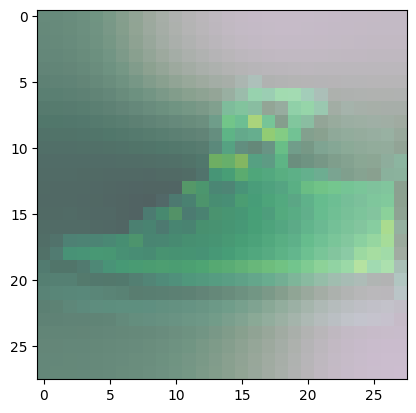

Predicted Class = 7, Probability = 0.99514717


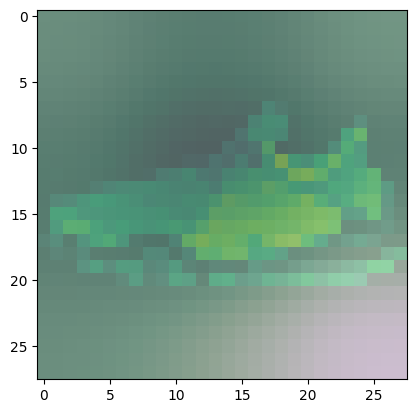

Predicted Class = 7, Probability = 0.99990124


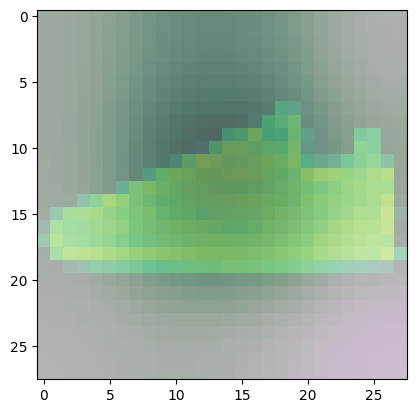

Predicted Class = 7, Probability = 0.9998923


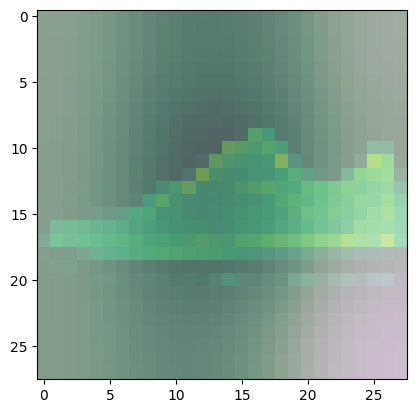

Predicted Class = 7, Probability = 0.9996767


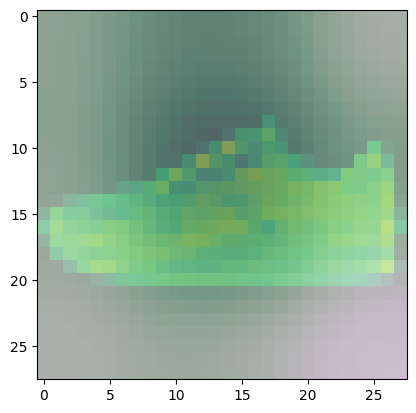

Predicted Class = 7, Probability = 0.9650402


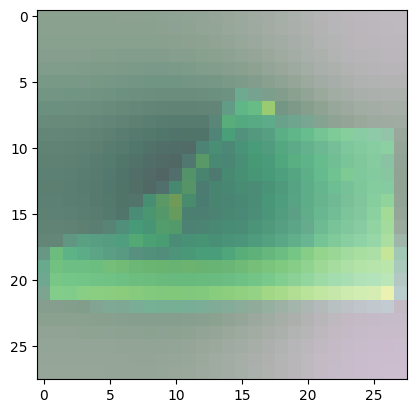

Predicted Class = 7, Probability = 0.9999116


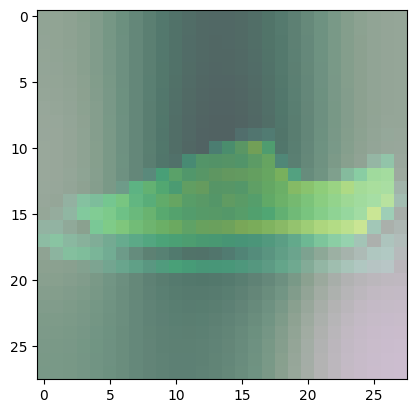

Predicted Class = 7, Probability = 0.99632734


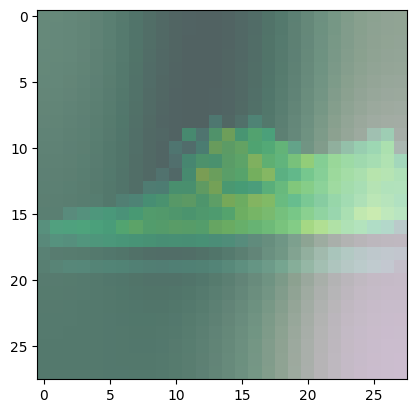

Predicted Class = 7, Probability = 0.9908832


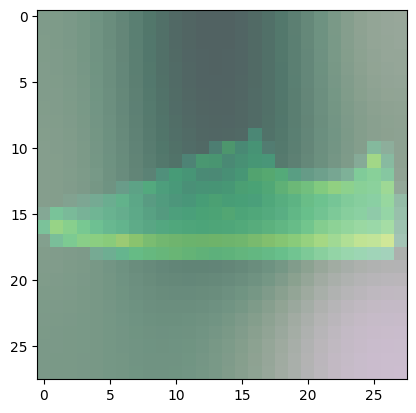

Predicted Class = 7, Probability = 0.9984606


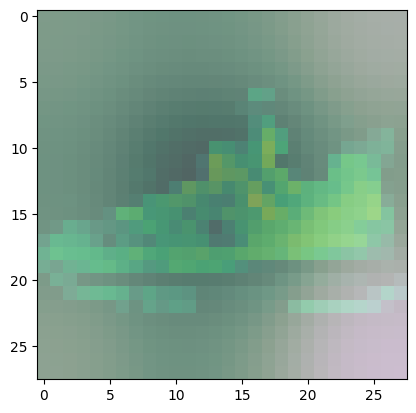

Predicted Class = 7, Probability = 0.9925161


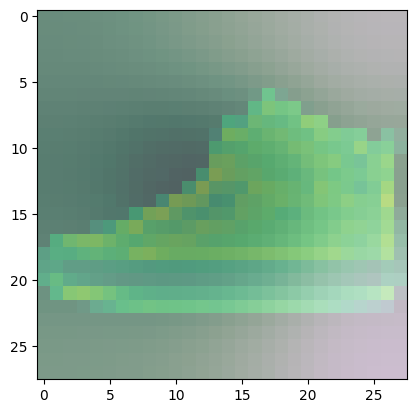

Predicted Class = 7, Probability = 0.99946797


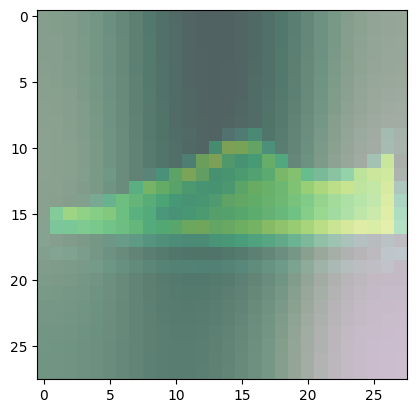

In [18]:
show_maps(desired_class=7, num_maps=20)